© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 📚 Multiclass Models

So far, we've focused exclusively on **binary classification**, where the label set has just two elements:  $|\mathcal{Y}| = 2$. However, most real-world datasets involve **multiple classes**: $|\mathcal{Y}| > 2$. This session introduces strategies to extend our linear models and classifiers to the **multiclass setting**.

Given a dataset with $K$ classes, i.e., $\mathcal{Y} = \{1, 2, \dots, K\}$, our goal is to build a model that predicts the correct class label for each input. There are two main strategies to do this:

- **One-vs-Rest (OvR) strategy** $\approx$ **Multioutput models** (focus of this class)
- **One-vs-One (OvO) strategy** 


## One-vs-Rest Strategy

The **one-vs-rest** (OvR) strategy decomposes the multiclass task into $K$ binary classification problems. Each classifier $h_k$ is trained to distinguish **class $k$** from **all other classes**. To make a final prediction, we select the class with the **highest score**:

$$
h(x) = \underset{k \in \{1, \dots, K\}}{\operatorname{argmax}} \; h_k(x)
$$


### 🔧 Example: Linear (Least Squares) Regression (OvR)

Assume:
- $X \in \mathbb{R}^{N \times d}$ — data matrix
- $Y \in \{1, \dots, K\}^N$ — multiclass labels

We represent $K$ binary classifiers of the form $h_k(x) = \langle x, w_k \rangle + b_k$ as one matrix equation:

$$
H(X) = [h_1(X), \dots, h_K(X)] = XW + B \in \mathbb{R}^{N \times K}
$$

Where:
- $W \in \mathbb{R}^{d \times K}$ — weight matrix (each column corresponds to one class)
- $B = [b_1 \mathbf{1}_N, \dots, b_K \mathbf{1}_N] \in \mathbb{R}^{N \times K}$ — broadcasted bias matrix, where each column is $b_k \mathbf{1}_N$


### 🏷️ Label Encoding

We encode the labels into a matrix $\tilde{Y} \in \{-1, 1\}^{N \times K}$ such that:

- $\tilde{Y}[i, k] = 1$ if sample $i$ belongs to class $k$
- $\tilde{Y}[i, k] = -1$ otherwise

This allows us to use a single loss for all classes:

$$
\min_{W, B} \left\| XW + B - \tilde{Y} \right\|_2^2 = \sum_{k=1}^K \left\| Xw_k + b_k \mathbf{1}_N - \tilde{Y}_{:,k} \right\|_2^2
$$

🧩 Each classifier (column) is trained **independently**, just like in one-vs-rest.


## One-vs-One Strategy

The **one-vs-one** (OvO) strategy trains a binary classifier for **every pair of classes**.

- Total classifiers: $\frac{K(K-1)}{2}$
- Prediction is made by **majority vote** across all pairwise classifiers

We won’t explore this in depth, but it’s useful e.g. when working with **kernel methods** (QP solvers are hard computationally less practical in multi-output setting).


## Multioutput Regression / Classification

We can also simply view multiclass regression/classification as **vector-valued prediction**, treat labels as vectors in $\mathbb{R}^K$ and train a model to output:

$$
f(x) \in \mathbb{R}^K
$$

Then the optimization problem is to minimize a **multidimensional loss**, e.g., squared error.

✅ The optimization problem of least squares OvR model is equivalent to a **multioutput linear regression model**.



# 🛠️ Implementation of Multiclass Linear Classification

We now implement the `LinearMulticlassClassification` class for **multiclass linear classification**. This class closely follows the structure of our binary classifier, but is adapted to handle vector-valued outputs for $K$ classes.

- ✅ **Weight and bias structure:** The weight matrix `w` has shape $(d, K)$, and the bias vector `b` is stored as a row vector with shape $(1, K)$. This allows for matrix multiplication and broadcasting in the decision function.

- ✅ **Decision function:** The model computes class scores for each class $k$ using a single matrix operation:
  $$
  H(X) = XW + B \in \mathbb{R}^{N \times K}
  $$
  where $X$ is the input matrix, $W$ is the weight matrix, and $B$ is the broadcasted bias row.

- ✅ **Prediction:** To obtain the final predicted class label, the model returns:
  $$
  \hat{y}(x) = \arg\max_k H(x)_k
  $$

- ✅ **Gradient calculation:** The model uses the squared loss between the predicted score matrix and the encoded label matrix (e.g., in $\{-1, 1\}$ format). The gradients are computed in a fully vectorized way for both `w` and `b`.


In [3]:
from courselib.models.base import TrainableModel

class LinearMulticlassClassification(TrainableModel):
    """
    Linear multiclass classifier with least-squares multioutput loss.
    Trained with gradient-based optimization.
    
    Parameters:
    - w: initial weight matrix, shape (d, K)
    - b: initial bias vector, shape (K,) or (1, K)
    - optimizer: an instance of Optimizer
    """

    def __init__(self, w, b, optimizer):
        super().__init__(optimizer)
        self.w = np.array(w, dtype=float)        # shape (d, K)
        self.b = np.array(b, dtype=float).reshape(1, -1)  # shape (1, K)

    def decision_function(self, X):
        """
        Computes class scores for input features X.

        Parameters:
        - X: input data, shape (N, d)

        Returns:
        - scores: array of shape (N, K)
        """
        return X @ self.w + self.b

    def loss_grad(self, X, Y):
        """
        Computes gradients of squared loss w.r.t. weights and biases.

        Parameters:
        - X: input features, shape (N, d)
        - Y: target matrix, shape (N, K), typically {-1, 1} encoding

        Returns:
        - gradients: dict with keys 'w' and 'b'
        """
        residual = self.decision_function(X) - Y           # (N, K)
        grad_w = X.T @ residual / len(X)                   # (d, K)
        grad_b = np.mean(residual, axis=0, keepdims=True)  # (1, K)

        return {"w": grad_w, "b": grad_b}

    def _get_params(self):
        """Returns current parameters as a dictionary."""
        return {"w": self.w, "b": self.b}

    def __call__(self, X):
        """
        Predicts class labels using the decision function.

        Parameters:
        - X: input features, shape (N, d)

        Returns:
        - labels: predicted class indices, shape (N,)
        """
        return np.argmax(self.decision_function(X), axis=-1)


## 📐 Shape Handling

The code carefully handles shapes to ensure compatibility between inputs and parameters:
- Input data `X`: shape $(N, d)$
- Labels `Y`: expected to be already encoded to shape $(N, K)$
- `decision_function(X)` returns $(N, K)$
- Gradient shapes:
  - `grad_w`: $(d, K)$
  - `grad_b`: $(1, K)$

## 🔤 Labels Encoding

In multiclass classification, our model expects labels in a **matrix format** $\tilde{Y} \in \mathbb{R}^{N \times K}$, where each row corresponds to one training example, and each column corresponds to a class. We implement a function that:
- Accepts a 1D label array `Y`
- Optionally accepts a custom list of class labels (to fix class order)
- Accepts `pos_value` and `neg_value` -- values for the positive (true) and negative class 
- Returns an encoded matrix $\tilde{Y} \in \{-1, 1\}^{N \times K}$

For linear (OLS) model, we choose label values to be $\{-1,1\}$ for consistency with the OvR strategy.

In [4]:
def labels_encoding(Y, labels=None, pos_value=1, neg_value=-1):
    """
    Encodes class labels into a one-vs-rest style matrix with custom values.

    Parameters:
    - Y: array-like of shape (N,) – class labels
    - labels: optional list of label values in desired order; if None, inferred from sorted unique values
    - pos_value: value for the positive (true) class (default: 1)
    - neg_value: value for the negative class (default: -1)

    Returns:
    - encoded: ndarray of shape (N, K), where K = number of classes
    """
    Y = np.asarray(Y)
    if labels is None:
        labels = np.unique(Y)
    label_to_index = {label: i for i, label in enumerate(labels)}
    
    K = len(labels)
    N = len(Y)
    
    encoded = np.full((N, K), neg_value, dtype=float)
    for i, y in enumerate(Y):
        k = label_to_index[y]
        encoded[i, k] = pos_value

    return encoded

# 🌸 Test the Multiclass Classifier on the Iris Dataset

We’ll test our model on the **Iris dataset**, now using all the three classes, and starting with the 2D projection for ease of visualization.

### Loading

In [5]:
from courselib.utils.loaders import load_irises

df = load_irises()

Loading from local `iris_data_set.csv`...


### Train-Test Split (2D projection)

In [6]:
from courselib.utils.splits import train_test_split

X, Y, X_train, Y_train, X_test, Y_test =  train_test_split(df[['sepal length [cm]', 'petal width [cm]','iris type']], 
                                                           training_data_fraction=0.8, 
                                                           class_column_name='iris type', 
                                                           return_numpy=True)

print('Training data split as follows:')
print(f'  Training data samples: {len(X_train)}')
print(f'      Test data samples: {len(X_test)}')

Training data split as follows:
  Training data samples: 120
      Test data samples: 30


### Visualize

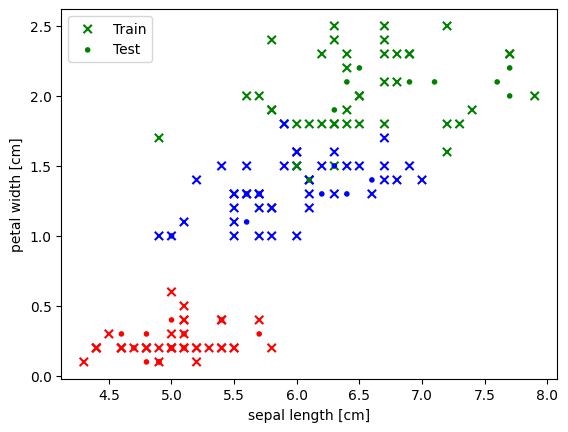

In [7]:
fig, ax = plt.subplots()

color_map = {'Iris-setosa': 'red', 'Iris-versicolor': 'blue', 'Iris-virginica': 'green'}

plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', 
            color=[color_map[y] for y in Y_train], label='Train')

plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', 
            color=[color_map[y] for y in Y_test], label='Test')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend()

### Encoding Labels

Note that so far the labels in `Y` are raw string names of the classes:

In [8]:
Y[:10]

array(['Iris-virginica', 'Iris-versicolor', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-versicolor', 'Iris-setosa', 'Iris-setosa'], dtype=object)

We encode the labels using our function to get the matrix form:

In [9]:
Y_train_encoded = labels_encoding(Y_train, pos_value=1, neg_value=-1) 

### Training

In [10]:
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import accuracy, mean_squared_error

K = Y_train_encoded.shape[1]  

W = np.zeros((X.shape[1],K))
b = [1]*K

metrics_dict = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}

optimizer = GDOptimizer(learning_rate=1e-2)
model = LinearMulticlassClassification(W,b, optimizer)
metrics_history = model.fit(X_train, Y_train_encoded, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

### Evaluating

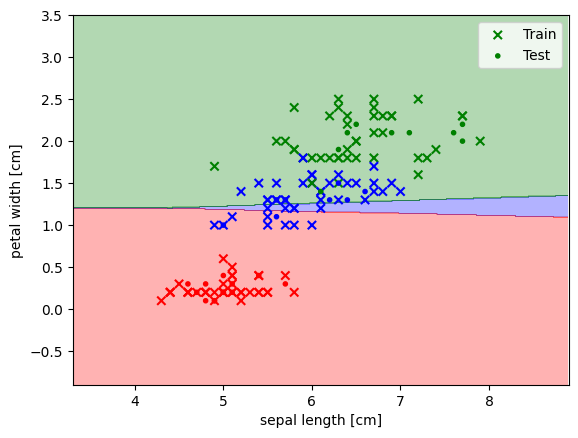

In [11]:
fig, ax = plt.subplots()

x1_min = X_train[:, 0].min() - 1
x1_max = X_train[:, 0].max() + 1
x2_min = X_train[:, 1].min() - 1
x2_max = X_train[:, 1].max() + 1

x1_list, x2_list = np.meshgrid(np.arange(x1_min, x1_max, .01), 
                               np.arange(x2_min, x2_max, .01))

X_list = np.dstack([x1_list, x2_list])
h_list = model(X_list)

cmap = matplotlib.colors.ListedColormap(['red', 'blue', 'green'])
plt.contourf(x1_list, x2_list, h_list, cmap=cmap, alpha=.3)

plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', 
            color=[color_map[y] for y in Y_train], label='Train')

plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', 
            color=[color_map[y] for y in Y_test], label='Test')


plt.xlabel('sepal length [cm]')
plt.ylabel('petal width [cm]')
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.legend()

The final train accuracy: 69.2%
Test accuracy: 73.3%


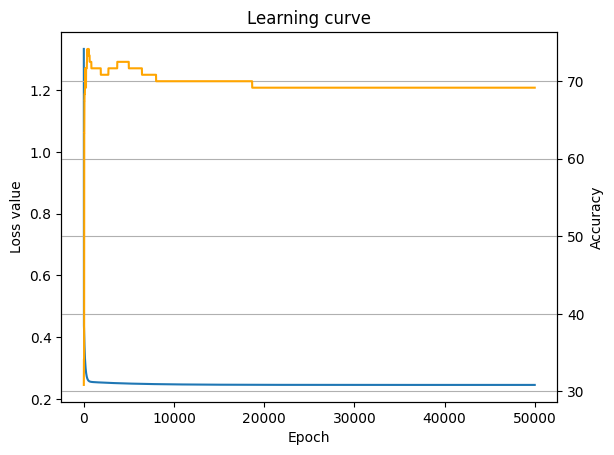

In [12]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(metrics_history['accuracy'][-1],1)}%')
print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), labels_encoding(Y_test)),1)}%')

## Train and Evaluate on the Full Dataset (All the Features) 

In [13]:
X, Y, X_train, Y_train, X_test, Y_test =  train_test_split(df, 
                                                           training_data_fraction=0.8, 
                                                           class_column_name='iris type', 
                                                           return_numpy=True)


In [14]:
Y_train_encoded = labels_encoding(Y_train, pos_value=1, neg_value=-1)
K = Y_train_encoded.shape[1]

W = np.zeros((X.shape[1],K))
b = [0]*K

optimizer = GDOptimizer(learning_rate=3e-2)
model = LinearMulticlassClassification(W,b, optimizer)
metrics_history = model.fit(X_train, Y_train_encoded, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

The final train accuracy: 87.5%
Test accuracy: 73.3%


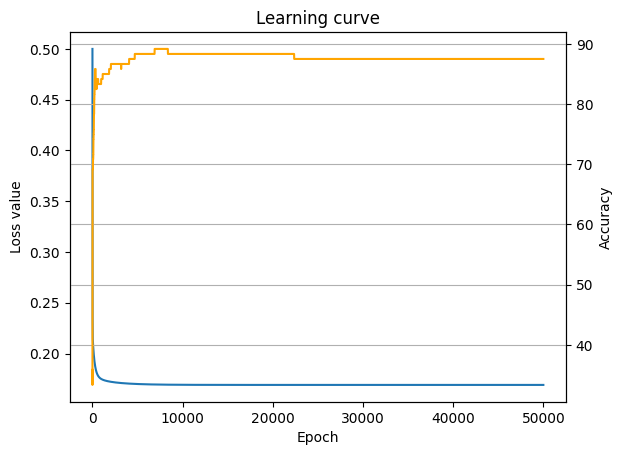

In [15]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(metrics_history['accuracy'][-1],1)}%')
print(f'Test accuracy: {round(accuracy(model.decision_function(X_test), labels_encoding(Y_test)),1)}%')

# Exercise — One-vs-Rest Logistic Regression

Implement a **multiclass logistic regression model** using the **one-vs-rest (OvR)** strategy. The model should output a $K$-dimensional score vector for each input using:

$$
h(x) = \alpha(XW + B)
$$

where $\alpha(t) = \dfrac{1}{1 + e^{-t}}$ is the **sigmoid function**, applied **component-wise** (i.e., per class).

The loss is a **multi-output binary cross-entropy**, summed over all classes:

$$
\mathcal{L}(W, B) = \frac{1}{NK} \sum_{i=1}^N \sum_{k=1}^K 
\left[ -y_i[k] \log(h_k(x_i)) - (1 - y_i[k]) \log(1 - h_k(x_i)) \right]
$$

This can be compactly written as:

$$
\min_{W, B} \; -\frac{1}{NK} \left\| 
Y \odot \log(h(X)) + (1 - Y) \odot \log(1 - h(X))
\right\|_1
$$

where:
- $Y \in \{0, 1\}^{N \times K}$ is the one-hot encoded label matrix
- $\odot$ denotes element-wise multiplication
- $\|\cdot\|_1$ denotes element-wise absolute sum (i.e., total loss over all entries)

Test on the Irises dataset and compare performance to the OLS model.
